In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate

from astropy.convolution import convolve, Box1DKernel
from astropy import constants as const
from astropy.modeling import models, fitting

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [3]:
wood = Table.read('wood21_all.csv')

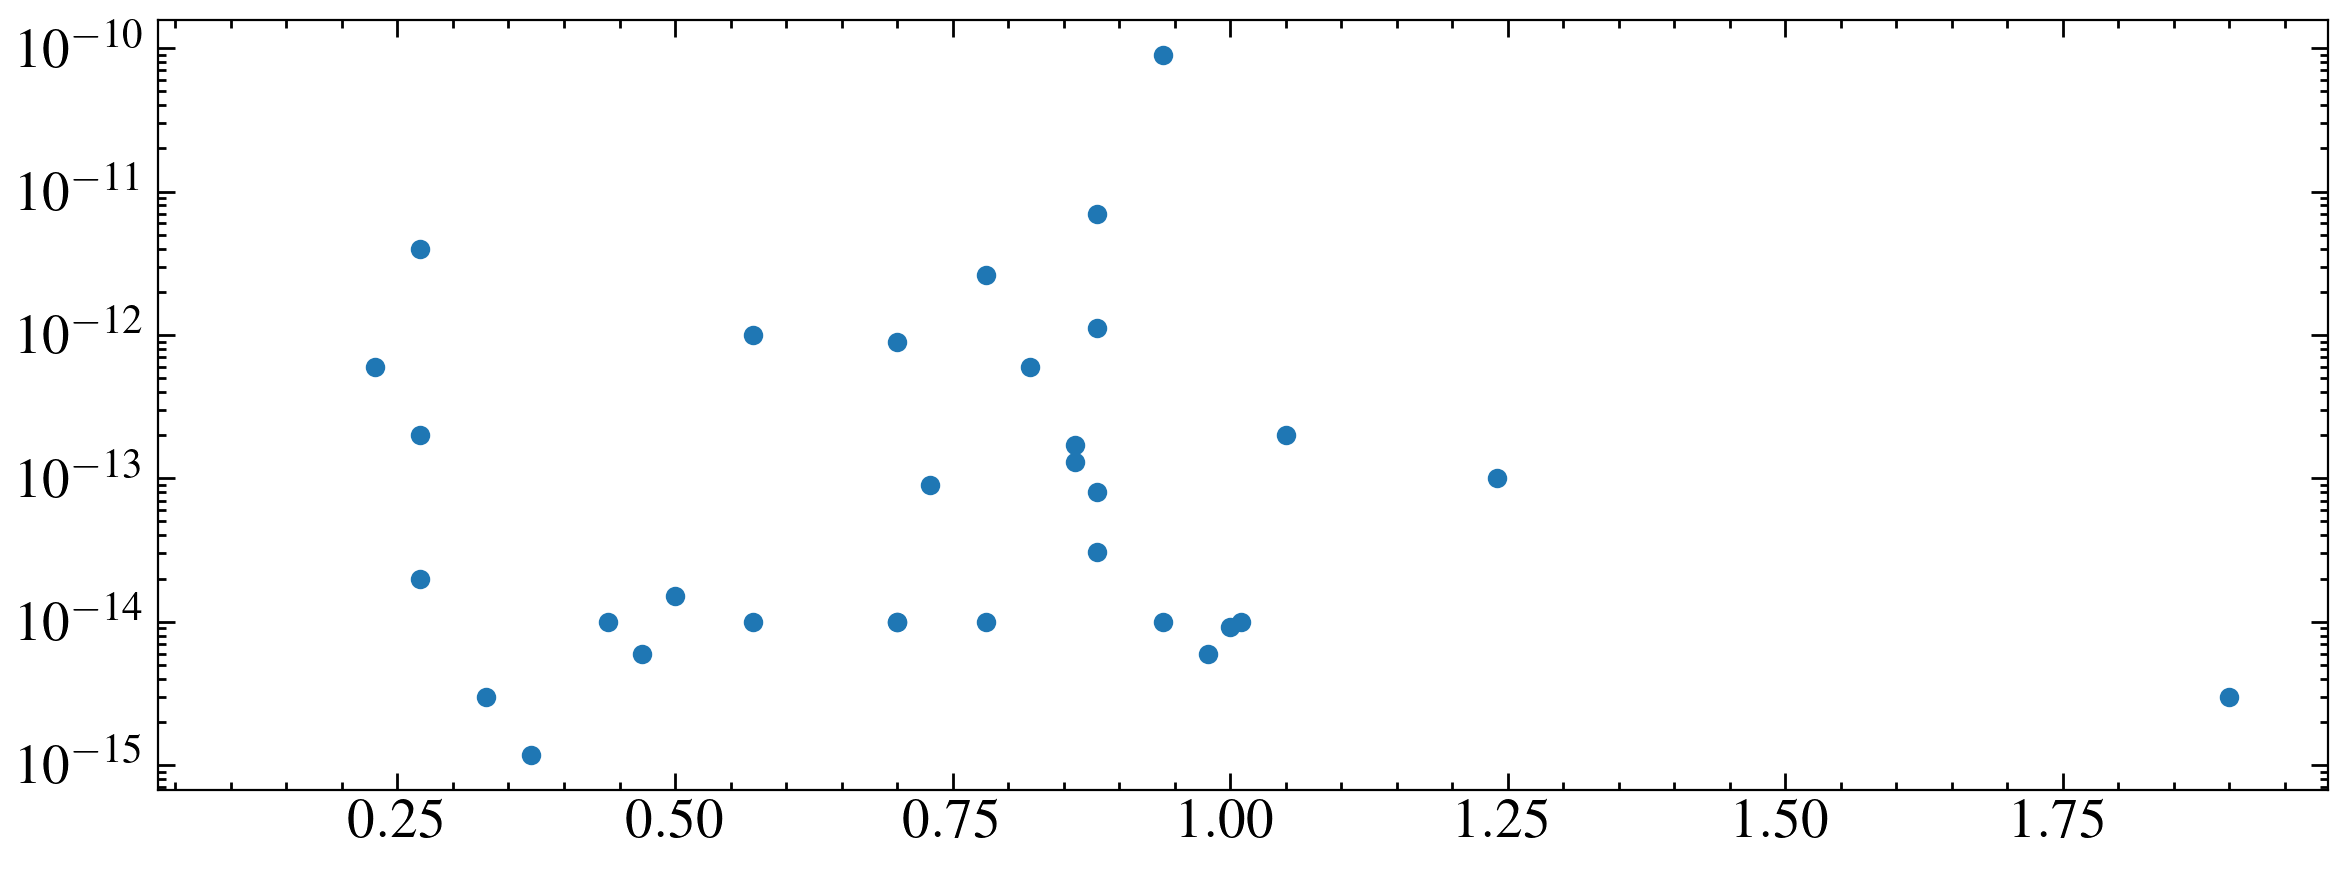

In [8]:
sol_n = 2e-14
sol = np.log10(2e-14)


fig, ax = plt.subplots()

ax.errorbar(wood['Mass est'], wood['Ṁdot (Ṁdotsun )']*sol_n, ls='none', marker='o')



ax.set_yscale('log')

In [9]:
rates = Table.read('tables/pceb_fit_results_rates.csv')
rates

Target,Teff,e_Teff,logg,e_logg,si,si_e,c,c_e,o,o_e,s,s_e,mass,q,tdiff_si,tdiff_c,tdiff_o,tdiff_s,Fsi,Fsi_e,Fc,Fc_e,Fo,Fo_e,Fs,Fs_e,porb_min,spt,mass_est,rad_est,lum_est,lx,lxel,lexeu
str11,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64
V-UZ-SEX,17146,15,7.801,0.007,-7.08,0.03,-6.21,0.05,-6.44,0.07,-7.36,0.3,0.511,-16.343,-1.997,-2.272,-2.135,-2.272,336385.0913,15320.37649,2008822.103,152446.5769,1149357.541,122104.1368,379599.6727,172820.6755,860.0,M4,0.22,0.258,-2.51,5.56e+27,1.31e+27,4.21e+26
V-LM-COM,28878,1122,7.358,0.1,-6.96,0.04,-5.9,0.04,-5.63,0.0,-6.96,0.0,0.424,-15.4,-0.913,-1.069,-1.024,-1.069,265938.7946,19504.52052,1870193.033,137163.9607,4182154.821,0.0,434781.2289,0.0,373.0,M3,0.36,0.369,-1.79,-5.6e+28,0.0,0.0
WD-1339+606,37074,76,7.449,0.005,-7.88,0.4,-8.32,0.1,-8.05,0.4,-7.34,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356.0,M3,0.36,0.369,-1.79,-9e+28,0.0,0.0
WD-1504+546,21730,53,7.67,0.01,-7.13,0.2,-8.25,0.09,-8.15,0.3,-7.43,0.6,0.464,-15.894,-1.515,-1.609,-1.758,-1.609,252309.6261,76582.37196,10163.38924,1388.40783,24018.85112,10935.24372,179235.037,163201.1191,1340.0,M3,0.36,0.369,-1.79,9.26e+28,3.62e+28,3.74e+28
WD-2317+268,28403,19,7.585,0.005,-6.78,0.03,-5.82,0.03,-4.66,0.1,-6.65,0.2,0.452,-15.541,-1.068,-1.232,-1.195,-1.232,443153.5923,20179.70829,2521500.235,114820.5499,44583348.57,6765937.313,995504.8128,302149.8672,1140.0,M3,0.36,0.369,-1.79,-2.4e+28,0.0,0.0
WD-1436-216,22814,38,7.658,0.01,-7.19,0.05,-6.27,0.1,-5.92,0.4,-8.18,0.1,0.463,-15.83,-1.453,-1.548,-1.699,-1.548,220291.0386,16721.78698,975217.6868,148009.902,4117325.866,2499337.128,32024.76269,4860.434806,2910.0,M2,0.44,0.434,-1.54,5.07e+28,9.84e+26,7.8e+26
WD-1458+171,21406,4,7.445,0.0003,-6.19,0.3,-5.09,0.04,-5.96,0.0,-6.51,0.0,0.399,-15.65,-1.25,-1.344,-1.496,-1.344,1800481.797,819703.8918,12036313.03,730638.5581,3069072.482,0.0,1221455.993,0.0,237.0,M4,0.22,0.258,-2.51,3.7e+28,1.18e+28,8.42e+27
WD2257+162,22886,33,7.24,0.008,-7.38,0.05,-6.27,0.05,-8.03,0.5,-7.34,0.1,0.404,-15.587,-1.19,-1.288,-1.439,-1.288,118521.5178,8995.775491,818280.0127,62107.39973,26817.33484,20348.5671,185902.9555,28213.98152,464.0,M4.5,0.18,0.243,-2.84,0.0,0.0,0.0
WD2256+249,21488,17,7.73,0.006,-6.88,0.02,-5.76,0.02,-5.72,0.05,-7.39,0.2,0.49,-15.996,-1.622,-1.719,-1.862,-1.719,479304.9558,14557.21339,3378443.483,102608.4168,6858518.74,520467.5137,211398.0657,64162.43974,250.0,M4,0.22,0.258,-2.51,0.0,0.0,0.0


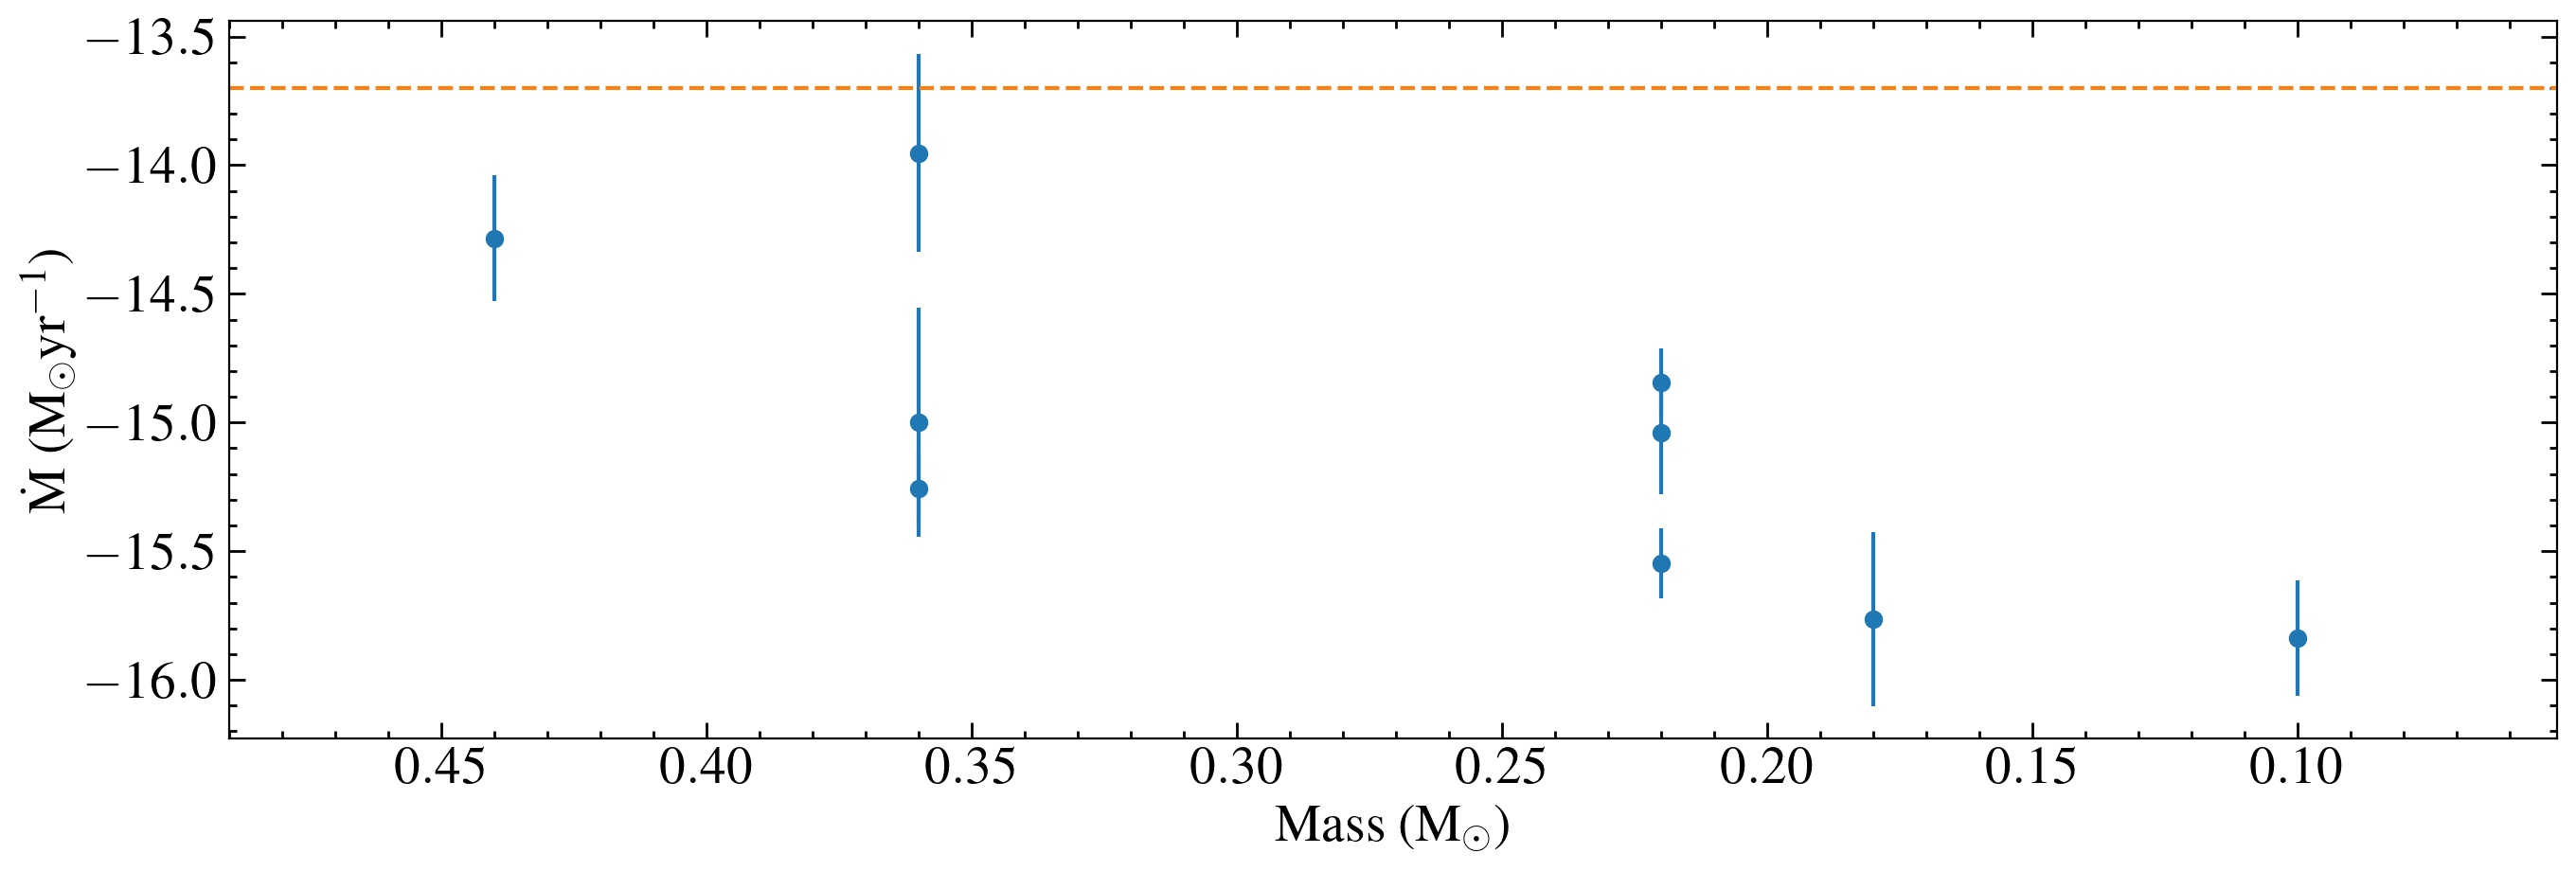

In [10]:
els = ['si', 'c', 'o', 's']
el_mass = [28.085, 12.011, 15.999, 32.06]
sol_frac = [6.649e-4, 2.365e-3,5.733e-3, 3.093e-4]

def find_v(a, Rrd, Mrd, Mwd, p):
    """
    velocity of the stellar wind at distance a
    """
    a, Rrd, Mrd, Mwd, p = a.to(u.m), Rrd.to(u.m), Mrd.to(u.kg), Mwd.to(u.kg), p.to(u.s)
    vorb = (2*np.pi/p) * a * (Mrd/(Mrd+Mwd)) #orbital velocity of wd
#     print('vorb=', vorb)
    vwind = ((2*const.G*Mrd)/Rrd)**0.5 #approximate as escape velocity
#     print('vwind=' , vwind)
    vrel = (vwind**2+vorb**2)**0.5
    return vrel

def mass_loss(mdot, Mwd, a, v): 
    """mass loss rate of mdwarf to produce an accretion rate mdot onto a white dwarf of mass Mwd at separation a"""
#     m_loss = (((2*a*Mrd)/(Rrd*Mwd))**2) * mdot
#     print(Mwd, Mrd)
    mdot, Mwd, a, v =  mdot.to(u.g/u.s), Mwd.to(u.kg), a.to(u.m), v.to(u.m/u.s)
#     print(v)
  #  v= 600000*u.m/u.s
#     print(a.to(u.Rsun))
   # print(v)
#     print (mdot, Mwd, a, v)
    scale = (v**4*a**2)/(const.G**2*Mwd**2)
#     print('scale=',scale)
    m_loss = mdot*scale
    return m_loss

def total_infer(mdot, el):
#     print(el)
    els = np.genfromtxt('solar_abd.tsv', names=True, delimiter='\t', dtype=None, encoding=None)
    mf = els['mass_fraction'][np.where(els['Atom_X']==el)][0]
    total_mdot = mdot/mf
    return total_mdot

def p_to_a(m1, m2, p):
    m1, m2, p = m1.to(u.kg), m2.to(u.kg), p.to(u.s)
    a = ((const.G*(m1+m2) * p**2)/(4*np.pi**2))**(1/3)
#     print(a.to(u.Rsun))
    return a
                                   
def find_wind(mdot, Mwd,p, Rrd, Mrd, el):
#     print(el)
#     print(mdot)
    a = p_to_a(Mwd, Mrd, p)
    v = find_v(a, Rrd, Mrd, Mwd, p)
    rate = mass_loss(mdot, Mwd, a, v)
#     print(rate)
#     print(rate)
    total = total_infer(rate, el.capitalize())
#     print(total)
    return(total)

wind_names = []
wind_rates = []
wind_errors = []
masses = []
sptypes = [] 
for row in rates:
#     if row['Target'] == 'WD0710+741':
    if row['Teff'] < 30000:
        masses.append(row['mass_est'])
        sptypes.append(row['spt'])
        mdots = []
        for i, el in enumerate(els):
            if row['{}_e'.format(el)] > 0.0:
                acc = row['F{}'.format(el)]*(u.g/u.s)
                Mwd, Mrd = row['mass']*u.M_sun, row['mass_est']*u.M_sun
                Rrd = row['rad_est']*u.R_sun 
                p = row['porb_min']*u.min
#                 print(p)
                mdot = find_wind(acc, Mwd,p, Rrd, Mrd, el)
                mdots.append(mdot.value)
      #  print(mdots)
#         mdots = np.array(mdots)*u.g/u.s
     #   print(np.mean(mdots))
        wind_rates.append(np.mean(mdots))
        wind_errors.append(np.std(mdots))
        wind_names.append(row['Target'])

# print(wind_rates)
wind_rates = np.array(wind_rates)*(u.g/u.s).to(u.M_sun/u.yr)
wind_errors = np.array(wind_errors)*(u.g/u.s).to(u.M_sun/u.yr)

log_wind_rates = np.log10(wind_rates)
log_wind_errors = 0.434 * (wind_errors/wind_rates)
# print(np.log10(wind_rates))
masses= np.array(masses)

plt.errorbar(masses, log_wind_rates, yerr=log_wind_errors, marker='o', ls='none')
plt.xlim(0.49, 0.051)
plt.axhline(np.log10(2e-14), c='C1', ls='--')
plt.xlabel(r'Mass (M$_{\odot}$)')
plt.ylabel(r'\.M (M$_{\odot}$yr$^{-1}$)')
plt.tight_layout()
#  print(len(masses))
#print(masses)


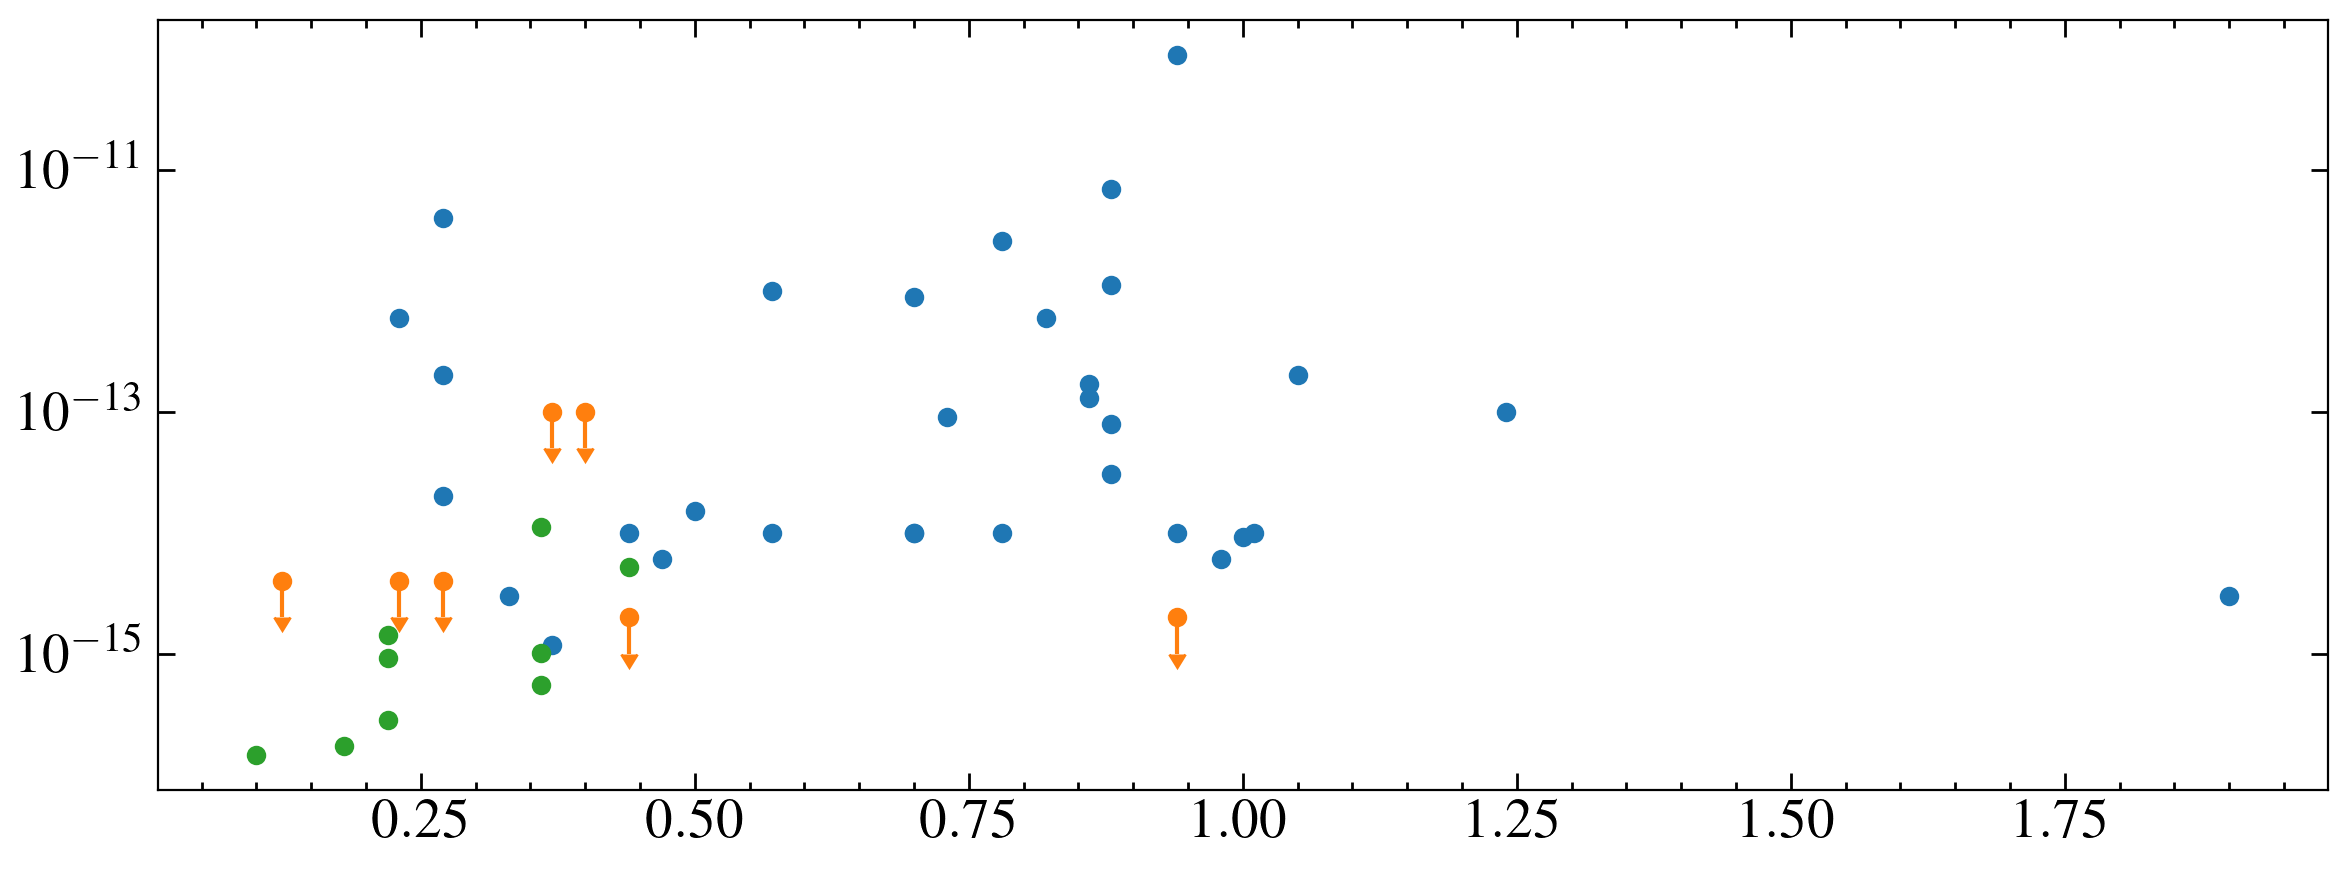

In [37]:
sol_n = 2e-14
sol = np.log10(2e-14)


fig, ax = plt.subplots()

woodmask = wood['Ṁdot (Ṁdotsun )'] > 0.0
ax.errorbar(wood['Mass est'][woodmask], wood['Ṁdot (Ṁdotsun )'][woodmask]*sol_n, ls='none', marker='o')
ax.errorbar(wood['Mass est'][~woodmask], -1*wood['Ṁdot (Ṁdotsun )'][~woodmask]*sol_n,  yerr = -0.5*wood['Ṁdot (Ṁdotsun )'][~woodmask]*sol_n, ls='none', marker='o', uplims=True)



ax.errorbar(masses, wind_rates, ls='none', marker='o')



ax.set_yscale('log')

In [17]:
walters = Table.read('walters+23.csv')
walters

Binary,Teff (K),logg,M2 (MJup),Spt,Period (h),[Ca/H],Cauplim,[Na/H],Nauplim,Accretion,BH capture,Edd capture
str11,int64,float64,int64,str2,float64,str5,str1,str4,str1,float64,float64,float64
Case 1,15500,8.07,380,M3,16.0,−8.1,--,--,--,2.6e-17,1.9e-15,1e-13
PG 1026+002,17200,7.96,380,M5,14.3,−8.6,--,--,--,6e-18,4.4e-16,2e-14
LHS 1660,7500,7.7,190,M5,7.3,−9.3,--,--,--,3.1e-16,9.9e-15,3e-13
PG 2257+162,24300,7.51,190,M5,7.7,--,--,--,--,3.1e-17,1.3e-16,3.2e-15
BPM 6502,22600,7.84,150,M5,8.1,--,--,--,--,1.4e-17,2.6e-16,1.3e-14
LTT 560,7500,7.75,150,M6,3.5,−7.5,--,--,--,8.5e-15,9.4e-14,3.1e-12
Rubin 80,8200,7.75,100,M7,4.0,−8.3,--,--,--,8.7e-16,1e-14,3.7e-13
GD 448,19700,7.49,100,M7,2.5,--,--,--,--,1.2e-17,7e-17,1.9e-15
NLTT 5306,7700,7.49,60,L5,1.7,−11.0,y,−7.7,--,3.3e-15,5.6e-15,2.1e-13


In [20]:
wmass = walters['M2 (MJup)']*u.Mjup.to(u.Msun)


0.36274580890834346
0.36274580890834346
0.18137290445417173
0.18137290445417173
0.14318913509539874
0.14318913509539874
0.09545942339693249
0.09545942339693249
0.0572756540381595
0.06682159637785275
0.0572756540381595


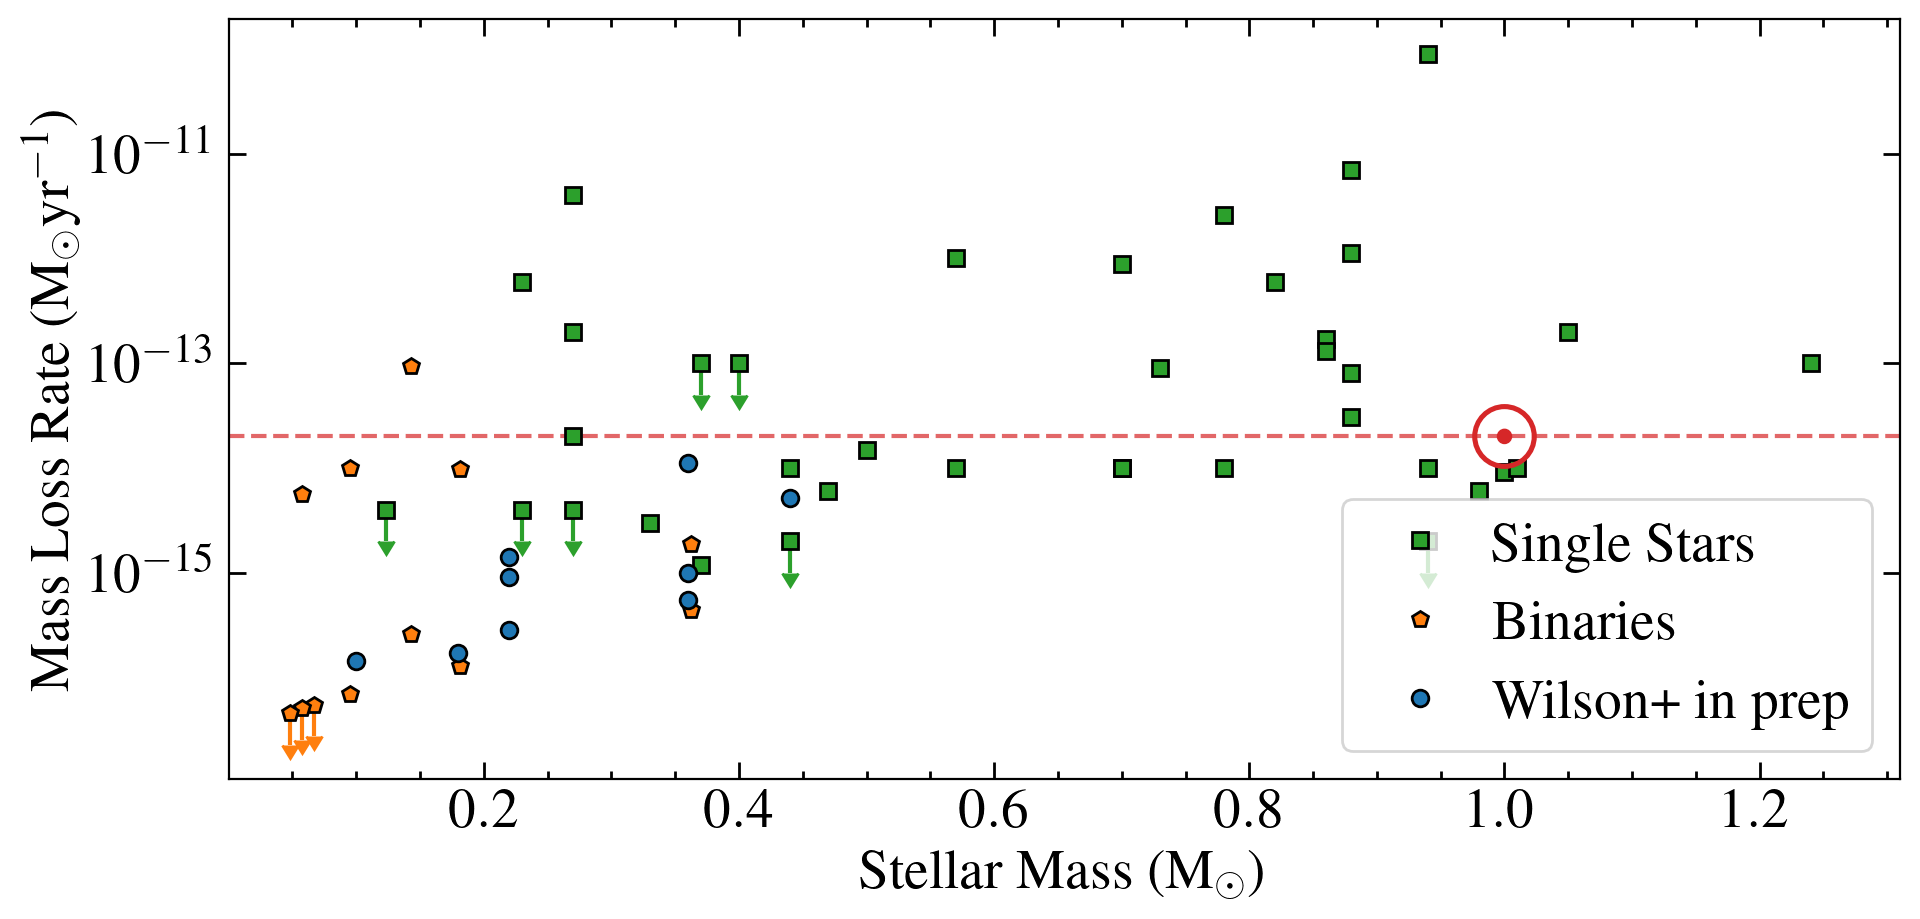

In [69]:
sol_n = 2e-14
sol = np.log10(2e-14)


fig, ax = plt.subplots(figsize=(10, 5))

woodmask = wood['Ṁdot (Ṁdotsun )'] > 0.0
ax.errorbar(wood['Mass est'][woodmask], wood['Ṁdot (Ṁdotsun )'][woodmask]*sol_n, ls='none', marker='s', markeredgecolor='k', c='C2', label='Single Stars')
ax.errorbar(wood['Mass est'][~woodmask], -1*wood['Ṁdot (Ṁdotsun )'][~woodmask]*sol_n,  yerr = -0.5*wood['Ṁdot (Ṁdotsun )'][~woodmask]*sol_n, ls='none',marker='s', markeredgecolor='k', uplims=True, c='C2')




walmask = walters['BH capture'] > 0.0
ax.errorbar(wmass[walmask], walters['BH capture'][walmask],  ls='none', marker='p', markeredgecolor='k', c='C1', label='Binaries')
ax.errorbar(wmass[~walmask], -1*walters['BH capture'][~walmask], yerr=-0.5*walters['BH capture'][~walmask], uplims=True,  ls='none', marker='p', markeredgecolor='k', c='C1')

ax.errorbar(masses, wind_rates, ls='none', marker='o',  markeredgecolor='k', c='C0' , label='Wilson+ in prep')


ax.scatter(1, sol_n, marker = '$\odot$', s=500, c='C3', zorder=10)
ax.axhline(sol_n, ls='--', c='C3', alpha=0.7)

ax.set_yscale('log')
ax.legend(frameon=True, loc=4)

ax.set_ylabel('Mass Loss Rate ($\mathrm{M}_{\odot}\mathrm{yr}^{-1}$)')
ax.set_xlabel('Stellar Mass ($\mathrm{M}_{\odot}$)')

ax.set_xlim(0.0001, 1.31)

fig.tight_layout()

fig.savefig('plots/all_mdots.png', facecolor='w')

In [31]:
wood['Ṁdot (Ṁdotsun )'][~woodmask]

-0.2
-0.2
-0.1
0.0
0.5
-0.2
0.15
0.0
1.0
...
0.5
